In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# 读取Excel文件到DataFrame中
df = pd.read_csv('/root/2023mcm/new_data.csv', header=0)

# 反向索引DataFrame
reversed_df = df.iloc[::-1]

# 打印反向排序后的DataFrame
df=reversed_df
# 将日期列转换为时间戳格式
df["Date"] = pd.to_datetime(df["Date"])

In [2]:
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,Percent in 1 try,2 tries,3 tries,4 tries,5 tries,...,consonant_cluster_col,vowel_cluster_col,consonant_vowel_consonant_col,count_duplicate_letters_col,count_duplicate_types_col,get_phonemes_col,has_diacritics_col,count_similar_words_col,Unnamed: 21,week
357,2022-01-07,202,slump,80630,1362,0.0,2.020202,17.171717,37.373737,29.292929,...,1,0,1,0,0,sləmp,1,2,0.016892,5
356,2022-01-08,203,crank,101503,1763,0.0,4.040404,21.212121,38.383838,26.262626,...,1,0,1,0,0,kræŋk,1,6,0.017369,4
355,2022-01-09,204,gorge,91477,1913,0.0,2.000000,16.000000,38.000000,30.000000,...,0,0,1,2,1,gɔrʤ,1,4,0.020912,3
354,2022-01-10,205,query,107134,2242,0.0,3.030303,21.212121,40.404040,25.252525,...,0,1,0,0,0,kˈwiri,1,4,0.020927,2
353,2022-01-11,206,drink,153880,3017,0.0,2.000000,17.000000,35.000000,29.000000,...,1,0,1,0,0,drɪŋk,1,4,0.019606,1


In [4]:
import pandas as pd
from scipy.stats import skew, kurtosis

# 读取数据
df = pd.read_csv('/root/2023mcm/new_data.csv', header=0)

# 提取第六列至第12列的数据
data = df.iloc[:, 5:12].values

# 计算每行数据的峰度系数和偏度系数
kurtosis_values = []
skewness_values = []
for i in range(data.shape[0]):
    kurtosis_values.append(kurtosis(data[i]))
    skewness_values.append(skew(data[i]))

# 找到最接近正态分布的行数
normality_scores = [abs(kurt) + abs(skewness) for kurt, skewness in zip(kurtosis_values, skewness_values)]
most_normal_row = normality_scores.index(min(normality_scores))

# 打印结果
print(f"Most normal row is row {most_normal_row}, with a normality score of {normality_scores[most_normal_row]:.2f}")
print(f"Kurtosis: {kurtosis_values[most_normal_row]:.2f}")
print(f"Skewness: {skewness_values[most_normal_row]:.2f}")
print(f"Data: {data[most_normal_row]}")

Most normal row is row 315, with a normality score of 1.15
Kurtosis: -0.07
Skewness: 1.08
Data: [ 0.  2. 23. 49. 20.  5.  1.]


In [5]:
from sklearn.metrics.pairwise import cosine_similarity
attributes = df.iloc[314, [12,13,14,15,16,17,19,20]].values

In [6]:
attributes

array([0.0, 1, 0, 1, 2, 1, 1, 3], dtype=object)

In [ ]:
import re
import eng_to_ipa
import jellyfish
import nltk
from nltk.corpus import words
from nltk.corpus import brown

nltk.download("words")
nltk.download('brown')


class WordFeatures:
    def __init__(self):
        self.consonants = set('bcdfghjklmnpqrstvwxyz')
        self.vowels = set('aeiou')

    def consonant_cluster(self, word):
        pattern = re.compile(
            r"(bl|br|ch|cl|cr|dr|fl|fr|gl|gr|pl|pr|sc|sh|sk|sl|sm|sn|sp|st|sw|th|tr|tw|wh|wr)[aeiouy]")
        if pattern.search(word.lower()):
            return 1
        else:
            return 0

    def vowel_cluster(self, word):
        pattern = re.compile(r'[aeiou]{2,}')
        match = re.search(pattern, word)
        if match:
            return 1
        else:
            return 0

    def consonant_vowel_consonant(self, word):
        if len(word) < 3:
            return 0
        for i in range(len(word)-2):
            if (word[i] in self.consonants) and (word[i+1] in self.vowels) and (word[i+2] in self.consonants):
                return 1
        return 0

    def count_duplicate_letters(self, word):
        counts = {}
        for letter in word:
            if letter in counts:
                counts[letter] += 1
            else:
                counts[letter] = 1
        duplicates = sum(count for count in counts.values() if count > 1)
        return duplicates

    def count_duplicate_types(self, word):
        return len(set([letter for letter in word if word.count(letter) > 1]))

    def get_ipa(self, word):
        return eng_to_ipa.convert(word)

    def has_diacritics(self, word):
        pattern = re.compile(r'[^\u0000-\u007F]')
        match = pattern.search(word)
        if match:
            return 1
        else:
            return 0

    def count_similar_words(self, word):
        word_list = words.words()
        similar_words = [w for w in word_list if len(w) == 5]
        count = 0
        for w in similar_words:
            if jellyfish.jaro_winkler(word, w) > 0.9:
                count += 1
        return count

    def word_frequency(self, word):
        corpus = brown.words()
        freq = corpus.count(word.lower())
        total_words = len(corpus)
        freq_percent = freq / total_words * 100
        return freq_percent

In [ ]:
import numpy as np
import nltk
from nltk.corpus import brown
from typing import List

nltk.download('brown')
nltk.download("words")

#from word_features import WordFeatures

# 获取5个字母的单词
word_list = [w for w in brown.words() if len(w) == 5]

# 初始化WordFeatures类
word_features = WordFeatures()

# 定义特征向量列表
feature_vectors = []

# 对每个单词进行特征提取，并将结果组成特征向量
for word in word_list:
    feature_vector = []
    feature_vector.append(word_features.consonant_cluster(word))
    feature_vector.append(word_features.vowel_cluster(word))
    feature_vector.append(word_features.consonant_vowel_consonant(word))
    feature_vector.append(word_features.count_duplicate_letters(word))
    feature_vector.append(word_features.count_duplicate_types(word))
    ipa_word = word_features.get_ipa(word)
    #feature_vector.append(ipa_word)
    feature_vector.append(word_features.has_diacritics(ipa_word))
    feature_vector.append(word_features.count_similar_words(word))
    feature_vector.append(word_features.word_frequency(word))
    feature_vectors.append(feature_vector)
    if len(feature_vectors) >= 5: # 仅保留前10个特征向量
        break
  

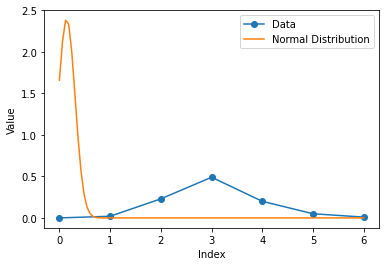

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 创建数据数组
data = np.array([0, 0.02, 0.23, 0.49, 0.20, 0.05, 0.01])

# 计算均值和标准差
mean = np.mean(data)
std = np.std(data)

# 创建正态分布对象
dist = norm(mean, std)

# 计算正态分布在指定范围内的值
x = np.linspace(0, 6, 100)
y = dist.pdf(x)

# 绘制数据和正态分布的对比图
plt.plot(range(len(data)), data, 'o-', label='Data')
plt.plot(x, y, label='Normal Distribution')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()



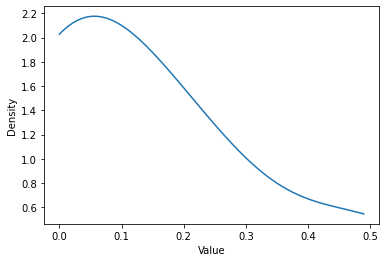

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 创建数据数组
data = np.array([0, 0.02, 0.23, 0.49, 0.20, 0.05, 0.01])

# 创建分布密度估计对象
kde = gaussian_kde(data)

# 创建分布密度曲线的 x 坐标
x = np.linspace(np.min(data), np.max(data), 100)

# 计算分布密度曲线的 y 坐标
y = kde(x)

# 绘制分布密度曲线
plt.plot(x, y)

plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


<Figure size 3000x2000 with 0 Axes>

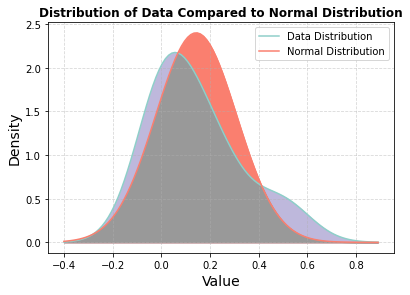

<Figure size 432x288 with 0 Axes>

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm

#创建数据数组
data = np.array([0, 0.02, 0.23, 0.49, 0.20, 0.05, 0.01])

#创建分布密度估计对象
kde = gaussian_kde(data)

#创建分布密度曲线的 x 坐标
x = np.linspace(np.min(data) - 0.4, np.max(data) + 0.4, 100)

#计算数据的分布密度曲线的 y 坐标
y = kde(x)

#创建正态分布对象
mean = np.mean(data)
std = np.std(data)
dist = norm(mean, std)
#
#计算正态分布在指定范围内的分布密度曲线值
nd_x = x
nd_y = dist.pdf(x)
#绘制数据的分布密度曲线并填充下面部分
fig = plt.figure(dpi=500)
fig, ax = plt.subplots()
ax.fill_between(x, y, alpha=1,color="#BEB8DC")
ax.fill_between(nd_x,nd_y,alpha=1,color="#FA7F6F")
#两曲线重叠部分的填充颜色使用#999999
ax.fill_between(x, np.minimum(y,nd_y), alpha=1, color="#999999")
#绘制正态分布的分布密度曲线
ax.plot(x,y,label="Data Distribution",color="#8ECFC9")
ax.plot(nd_x, nd_y, label='Normal Distribution',color="#FA7F6F")

ax.set_xlabel('Value',fontsize=14)
ax.set_ylabel('Density',fontsize=14)
ax.set_title('Distribution of Data Compared to Normal Distribution', fontweight='bold')
ax.legend()
ax.grid(True, which='both', linestyle='--', alpha=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()
plt.savefig('/root/2023mcm/q1', dpi=1048, bbox_inches='tight')